## This is used for viusalizing the trained embeddings from predict judge model (with no federal cases) and the predicting ruling model.

In [1]:
# Phu, Andrea and Watcher
# 2018 Spring
import numpy as np
import pandas as pd
import time
import os
import pickle
import string
import psutil
import sklearn

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from ggplot import *

import time
from sklearn.manifold import TSNE
import math

import seaborn as sns


/home/chewang/.conda/envs/judge_emb/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/chewang/.conda/envs/judge_emb/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/chewang/.conda/envs/judge_emb/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
processed_data_path = '/data/Dropbox/judge_embedding_data_sp18'
all_data_save_path = os.path.join(processed_data_path,"finalized_all_data","all_data_dict.pkl")
all_data_support_save_path = os.path.join(processed_data_path,"finalized_all_data","all_data_dict_support.pkl")
all_data_df_save_path = os.path.join(processed_data_path,"finalized_all_data","all_data_df.h5")
finished_embedding_folder_path = os.path.join(processed_data_path,'finished_judge_embedding')
plot_save_path = '/data/Dropbox/judge_embedding_data_sp18/plots'

## read in data for each case

In [3]:
all_data_dict = pickle.load(open(all_data_save_path,"rb"))
topic_glove_emb = all_data_dict['topic_glove_emb'][0]
judgeId2Index = all_data_dict['judge_id_to_index'][0]
judgeIndex2Id = all_data_dict['judge_index_to_id'][0]
all_data_df = all_data_dict['data_df']
all_data_df[:4]

,caseid,year,middle_part,opinion_text,songername,judgeidentificationnumber,topic,geniss,opinion_vector,judge_embed_index,Circuit,date,affirmdummy,judge_decision
0,XB0PMNQNB5G0,1891,contentMajOp,"[0, 202, 1268, 13, 0, 4600, 3, 0, 247954, 128,...","PARDEE, DON A.",1830.0,Civil Procedure,4.0,"[-0.07445931306292275, 0.05843820821632856, -0...",0,5,1891-12-07,0.0,0
1,XFL757,1891,contentMajOp,"[15, 116, 4, 9238, 7, 22547, 3, 4092, 1219, 0,...","BROWN, HENRY BILLINGS",284.0,Civil Procedure,4.0,"[-0.07101038203845275, 0.029874279749715626, -...",1,6,1891-10-06,0.0,0
2,XB0PMRQNB5G0,1891,contentMajOp,"[215, 6, 68193, 3527, 255, 9670, 5, 12375, 3, ...","PARDEE, DON A.",1830.0,Contracts,7.0,"[-0.059691082627907024, 0.10039284279069777, -...",0,5,1891-12-07,0.0,0
3,XFL7KI,1891,contentMajOp,"[5, 0, 935, 4951, 5, 8151, 0, 4490, 3, 0, 305,...","LOCKE, JAMES WILLIAM",1410.0,Civil Procedure,4.0,"[-0.13210430623456784, 0.12352108086419746, -0...",2,5,1891-11-27,0.0,0


In [4]:
# we now read in the judge bio data
judge_bio_path = os.path.join(processed_data_path,"JudgesBioReshaped_TOUSE.dta")
judge_bio_df = pd.read_stata(judge_bio_path)


In [5]:
pd.options.display.max_columns = 999
judge_bio_df

,songername,judgeidentificationnumber,Term,id,AppointmentDate,TerminationDate,courtname,courttype,abarating,AbaUpdate,SenateConfirmationdate,RecessAppointDate,birthday,birthmonth,birthyear,deathmonth,deathday,deathyear,JudgeAssignedCourt,judgelastname,judgefirstname,judgemiddlename,suffix,Circuitjudge,SeatState,retirementfromactiveservice,dateaschiefjudgebegin,presidentname,seconddateaschiefjudgebegin,senatevoicevote,senatevoteayesnays,Committeeactiondate,Degree1,Degree2,Degree3,Degree4,Degree5,degreeyear1,degreeyear2,degreeyear3,degreeyear4,degreeyear5,Committeeaction,ageon,vicelastnamepredecessor,vicefirstnamepredecessor,hearings,reportnumber,authorizationlegislation,placeofbirthcity,placeofbirthstate,placeofdeathcity,placeofdeathstate,deathdate,party_Updated,dateaschiefjudgeend,seconddateaschiefjudgeend,renominatingpresidentname,partyaffiliationofrenompres,referraldatejudicialcom,degree,degree_law,degree_other,district,nominationdatesenateexecutivej,genderNew,raceorethnicity,partyaffiliationofpresident,recessappointmentdate,committeeaction,committeeactiondate,senatevotedateconfirmationdate,commissiondate,dateoftermination,terminationspecificreason,nameofschool1,degree1,nameofschool2,degree2,nameofschool3,degree3,nameofschool4,degree4,nameofschool5,degree5,employmenttextfield,bankruptcyandmagistrateservice,Nominationdate,District_Circuit,party,pres,left,state,city,appres,aba,congresi,unityi,hdem,hrep,sdem,srep,hother,sother,x_dem,x_republican,x_instate_ba,x_elev,x_unity,x_aba,x_crossa,x_pfedjdge,x_pindreg1,x_plawprof,x_pscab,x_pcab,x_pusa,x_pssenate,x_paag,x_psp,x_pslc,x_pssc,x_pshouse,x_psg,x_psgo,x_psenate,x_psatty,x_pprivate,x_pmayor,x_plocct,x_phouse,x_pgov,x_pda,x_pcc,x_pccoun,x_pausa,x_pasatty,x_pag,x_pada,x_pgovt,x_llm_sjd,x_protestant,x_evangelical,x_mainline,x_noreligion,x_catholic,x_jewish,x_black,x_nonwhite,x_female,x_jd_public,x_ba_public,x_b10s,x_b20s,x_b30s,x_b40s,x_b50s,x_pbank,x_pmag,SchoolState1,Public1,Private1,SchoolState2,Public2,Private2,SchoolState3,Public3,Private3,SchoolState4,Public4,Private4,SchoolState5,Public5,Private5,TonotInclude,idtocorrrect,ayear,x_ageon40s,x_ageon50s,x_ageon60s,x_ageon40orless,x_ageon70ormore,pres_correct2,political_party,x_pago,startdate
0,"ABRAMS, RONNIE",3419,1,NaN,2012-03-23,NaT,"u. s. district court, southern district of new...",usdc,Qualified,,2012-03-22,NaT,NaN,NaN,1968.0,NaN,NaN,NaN,,ABRAMS,RONNIE,,,2,NY,,NaN,Barack Obama,NaN,No,96/2,2011-11-03,2.0,5.0,NaN,NaN,NaN,1990,1993,,,NaN,1.0,44.0,Kaplan,Lewis A.,10/04/2011,,,New York,NY,,,NaT,NaN,NaN,NaN,,,07/28/2011,,,,0208,07/28/2011,F,White,Democratic,,Reported With Recommendation,11/03/2011,03/22/2012,03/23/2012,,,Cornell University,B.A.,Yale Law School,J.D.,,,,,,,"Law clerk, Hon. Thomas P. Griesa, U.S. Distric...",,18836.0,,NaN,94.0,NaN,NaN,NaN,1.0,3.0,112TH,2.0,193.0,242.0,52,47,0.0,4.0,1.0,0.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NY,0.0,1.0,CT,0.0,1.0,,NaN,NaN,,NaN,NaN,,NaN,NaN,0.0,NaN,2012.0,1.0,0.0,0.0,0.0,0.0,NaN,,0.0,2012-03-23
1,"ABRUZZO, MATTHEW J.",1,1,2.0,1936-02-15,1971-05-28,"u. s. district court, eastern district of new ...",usdc,,,1936-02-12,NaT,30.0,4.0,1889.0,5.0,28.0,1971.0,Brooklyn,ABRUZZO,MATTHEW,T.,,2,NY,02/15/1966,NaN,Franklin D. Roosevelt,NaN,Yes,,1936-02-11,6.0,NaN,NaN,NaN,NaN,1910,,,,NaN,1.0,47.0,new,,,,49 Stat. 659,Brooklyn,NY,Potomac,MD,1971-05-28,1.0,NaN,NaN,,,02/03/1936,,,,0207,02/03/1936,M,White,Democratic,,Reported With Recommendation,02/11/1936,02/12/1936,02/15/1936,05/28/1971,Death,Brooklyn Law School,LL.B.,,,,,,,,,"Private practice, Brooklyn, New York, 1910-1936",,-8733.0,0207,1.0,14.0,3.0,32.0,3220.0,1.0,6.0,74TH,0.0,322.0,103.0,69,25,0.0,2.0,1.0,0.0,0.0,NaN,1.0,0.0,0.0,NaN,1.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

## define functions for plotting

In [6]:
def convertPublicLabel(label):
    if label == 1: # public
        return 'public'
    else:
        return 'private'
    
def convertYearLabelToDecade(label):
    return math.floor(label/10)*10 # e.g. 1931 is now 1930    

def get_df_plot(judge_bio_df,judgeIndex2Id):
    # return a dataframe containing all the 
    df_plot = pd.DataFrame()
    num_judges = len(judgeIndex2Id)
    df_plot['emb_index'] = [index for index in range(num_judges)]
    df_plot['gender'] = '' # gender: M/F
    df_plot['Circuitjudge'] = '' # circuit number
    df_plot['presidentname'] = ''
    df_plot['placeofbirthcity'] = ''
    df_plot['placeofbirthstate'] = ''
    df_plot['raceorethnicity'] = '' # White, Hispanic, etc
    df_plot['partyaffiliationofpresident'] = '' # Democratic, Republican, Reassignment
    df_plot['nameofschool1'] = ''
    df_plot['SchoolState1'] = ''
    df_plot['Public1'] = '' # public or private (convert from 0/1)
    df_plot['birthyear'] = '' # need conversion from year to maybe group by decade

    for judge_index in range(2099):
        judge_id = judgeIndex2Id[judge_index]
        judge_bio_rows = judge_bio_df.loc[judge_bio_df['judgeidentificationnumber']==judge_id]
        judge_bio_row = judge_bio_rows.iloc[0] # this is the first row
        df_plot.iat[judge_index,df_plot.columns.get_loc('gender')] = judge_bio_row['genderNew']
        df_plot.iat[judge_index,df_plot.columns.get_loc('Circuitjudge')] =str(int(judge_bio_row['Circuitjudge'])) 

        df_plot.iat[judge_index,df_plot.columns.get_loc('presidentname')] = judge_bio_row['presidentname']
        df_plot.iat[judge_index,df_plot.columns.get_loc('placeofbirthcity')] = judge_bio_row['placeofbirthcity']
        df_plot.iat[judge_index,df_plot.columns.get_loc('placeofbirthstate')] = judge_bio_row['placeofbirthstate']
        df_plot.iat[judge_index,df_plot.columns.get_loc('raceorethnicity')] = judge_bio_row['raceorethnicity']
        df_plot.iat[judge_index,df_plot.columns.get_loc('partyaffiliationofpresident')] = judge_bio_row['partyaffiliationofpresident']
        df_plot.iat[judge_index,df_plot.columns.get_loc('nameofschool1')] = judge_bio_row['nameofschool1']
        df_plot.iat[judge_index,df_plot.columns.get_loc('SchoolState1')] = judge_bio_row['SchoolState1']
        df_plot.iat[judge_index,df_plot.columns.get_loc('Public1')] =convertPublicLabel(judge_bio_row['Public1']) 
        df_plot.iat[judge_index,df_plot.columns.get_loc('birthyear')] = convertYearLabelToDecade(judge_bio_row['birthyear'])  
    return df_plot

In [10]:
def normalize_to_unit_emb(emb):
    # helper function used to normalize each vector in an
    # embedding matrix to be of unit length (might or might not be good)
    norms = np.linalg.norm(emb,axis=1).reshape(-1,1)
    
    n = norms.shape[0]
    for i in range(n):
        if norms[i] == 0:
            norms[i] = 1
    
    normalized_emb = emb/norms
    return normalized_emb

## really want a function here that just take in a embedding matrix and 
## visualize it according to certain parameters

def get_combined_df_plot(emb,df_plot, normalize_to_unit_length=False, PCA_dim=100, 
                  tsne_verbose=1,  tsne_perp = 40, tsne_iter=2000):
    # before we visualize stuff
    # this part only needs to be called once on an embedding
    # basically get x,y values for scatter plot
    if normalize_to_unit_length:
        emb = normalize_to_unit_emb(emb)
        
    # first do pca
    pca_reducer = PCA(n_components=PCA_dim)
    pca_result = pca_reducer.fit_transform(emb)
    
    # do tsne
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=tsne_verbose, perplexity=tsne_perp, n_iter=tsne_iter)
    tsne_results = tsne.fit_transform(pca_result)

    # now we put plotting x,y values into the dataframe
    df_plot['x-tsne'] = tsne_results[:,0]
    df_plot['y-tsne'] = tsne_results[:,1]
    return df_plot
    

def visualize_judge_emb(df_plot,emb_title="judge embedding",
                       size=50,alpha=0.3,listOfColorLabels=[],save_to_file=False,
                        save_prefix="fig",save_path="plots"):
    # given an df_plot, this function will visualize it
    # emb should be in np array form, 2099xD
    # df_plot should be a combined df_plot
    
    # use get_combined_df_plot to get a combined df_plot first 
    # and then use this function to create figures
    
    # the listOfColorLabels decide what coloring we will use to plot
    # the length of this list is how many plots we will generate in the end
    
    figures = [] # don'ts ave ggplot obj, just save the figures
    # otherwise get funny errors
    
    if len(listOfColorLabels) < 1: # if no coloring label specified then just do grey figure
        chart = ggplot(df_plot, aes(x='x-tsne', y='y-tsne')) \
            + geom_point(size=size,alpha=alpha) \
            + ggtitle(emb_title)
        chart.make()# call make to make the plot
        plt.tight_layout()
        fig = chart.fig # get reference to the figure, we can display this figure or save it as png
        figures.append(fig)
    
    for colorLabel in listOfColorLabels:
        # now we can do plotting
        chart = ggplot(df_plot, aes(x='x-tsne', y='y-tsne', color=colorLabel)) \
            + geom_point(size=size,alpha=alpha) \
            + ggtitle(emb_title)
        chart.make()# call make to make the plot
        plt.tight_layout()
        fig = chart.fig # get reference to the figure, we can display this figure or save it as png
        figures.append(fig)
    if save_to_file:
        for i in range(len(figures)):
            savePath = os.path.join(save_path,save_prefix+"_"+str(i)+".png")
            figures[i].savefig(savePath)
    
    return figures

## first let's read in the trained embedding from disk

In [20]:
judge_emb_path = os.path.join(finished_embedding_folder_path,"no_federal_trained_emb_May17.pkl")
no_fed_judge_emb = pickle.load(open(judge_emb_path,"rb"))

In [21]:
judge_emb_path = os.path.join(finished_embedding_folder_path,"pred_ruling_trained_emb_May17.pkl")
pred_ruling_judge_emb = pickle.load(open(judge_emb_path,"rb"))

In [24]:
# listOfColorLabels = ['gender','Circuitjudge','presidentname','placeofbirthstate',
#                      'raceorethnicity','partyaffiliationofpresident','SchoolState1',
#                      'Public1','birthyear']

listOfColorLabels_short = ['gender','Circuitjudge','presidentname',
                           'raceorethnicity','partyaffiliationofpresident','birthyear']
# we will not do cities since there are too many... can make the graph crush

## the following one cell is SAMPLE code to visualize an embedding in the simplest way
## When loaded judge embedding, run this cell to get plots

In [ ]:
# df_plot = get_df_plot(judge_bio_df,judgeIndex2Id) # df_plot contains each judge's info

# df_plot_combined = get_combined_df_plot(judge_emb, df_plot, normalize_to_unit_length=False, PCA_dim=10, 
#                   tsne_verbose=1,  tsne_perp = 50, tsne_iter=1000)
# figures = visualize_judge_emb(df_plot_combined,emb_title="judge embedding",
#                        size=50,alpha=0.3,listOfColorLabels=listOfColorLabels_short,save_to_file=False)

## Following are code to get a ton of plots

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.048s...
[t-SNE] Computed neighbors for 2099 samples in 3.510s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 0.108561
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.151443
[t-SNE] Error after 1500 iterations: 1.901202
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.192s...
[t-SNE] Computed neighbors for 2099 samples in 3.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 0.120285
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.712303
[t-SNE] Error after 1500 iterations: 1.783339
[t-SNE] Computin

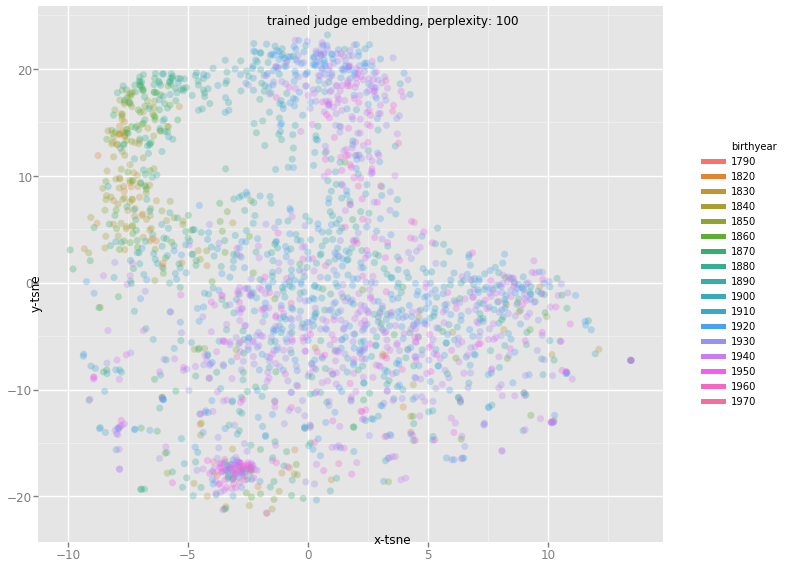

In [25]:
judge_emb = no_fed_judge_emb
perp_list = [15,25,50,100]
figures_list_trained1 = []
n_iter = 1500
save_prefix_first_part = "no_federal_trained"

for perp in perp_list:
    df_plot = get_df_plot(judge_bio_df,judgeIndex2Id) # df_plot contains each judge's info

    df_plot_combined = get_combined_df_plot(judge_emb, df_plot, normalize_to_unit_length=True, PCA_dim=50, 
                      tsne_verbose=1,  tsne_perp = perp, tsne_iter=n_iter)
    figures = visualize_judge_emb(df_plot_combined,emb_title="trained judge embedding, perplexity: "+str(perp),
                           size=50,alpha=0.3,listOfColorLabels=listOfColorLabels_short,save_to_file=True,
                                 save_prefix=save_prefix_first_part+str(perp),save_path=plot_save_path)
    figures_list_trained1.append(figures)

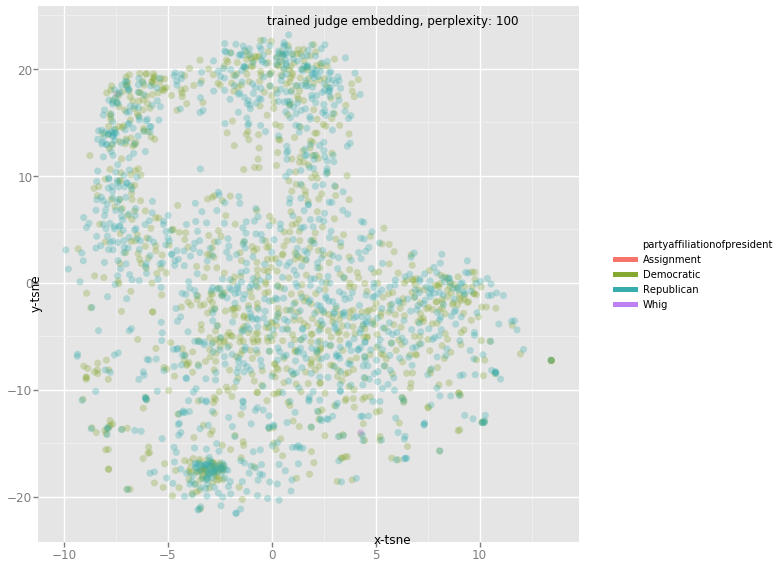

In [26]:
figures_list_trained1[3][4]

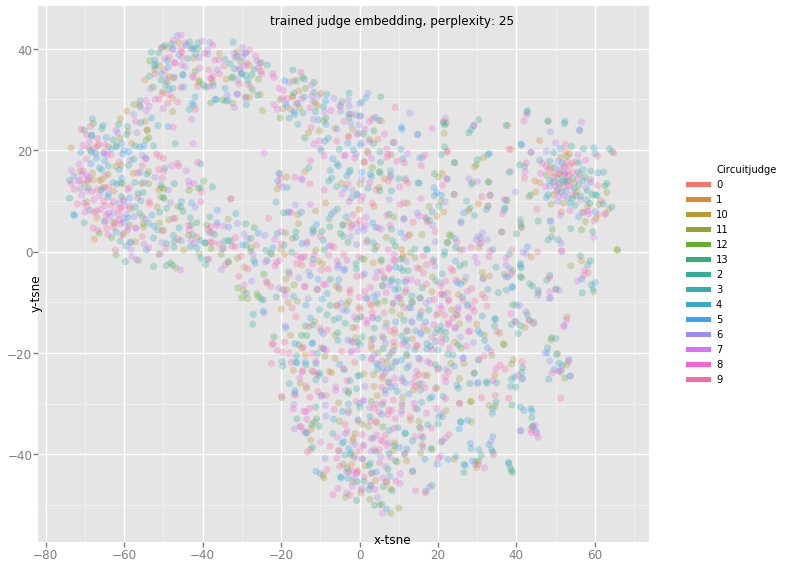

In [41]:
figures_list_trained1[1][1]

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.004s...
[t-SNE] Computed neighbors for 2099 samples in 4.518s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 0.188301
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.246246
[t-SNE] Error after 1500 iterations: 2.362960
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.006s...
[t-SNE] Computed neighbors for 2099 samples in 5.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 0.206934
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.851700
[t-SNE] Error after 1500 iterations: 2.179013
[t-SNE] Computin

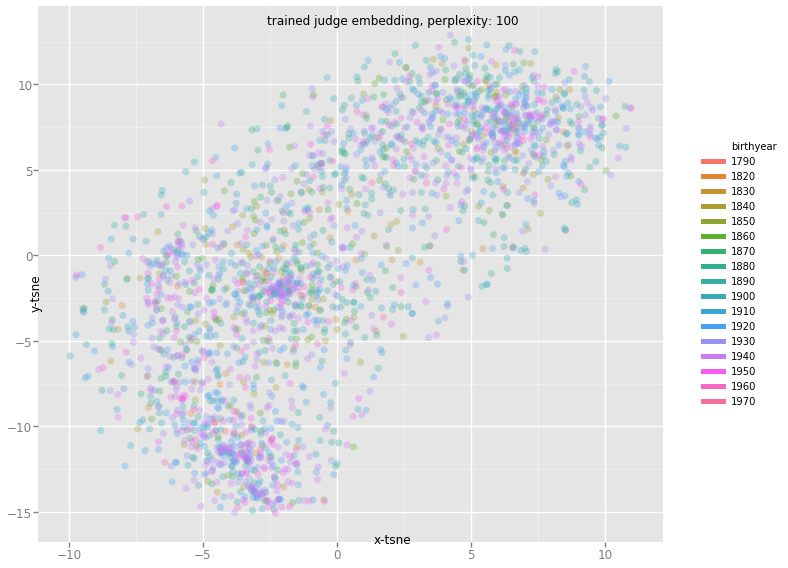

In [27]:
judge_emb = pred_ruling_judge_emb
perp_list = [15,25,50,100]
figures_list_trained2 = []
n_iter = 1500
save_prefix_first_part = "pred_ruling_trained"

for perp in perp_list:
    df_plot = get_df_plot(judge_bio_df,judgeIndex2Id) # df_plot contains each judge's info

    df_plot_combined = get_combined_df_plot(judge_emb, df_plot, normalize_to_unit_length=True, PCA_dim=50, 
                      tsne_verbose=1,  tsne_perp = perp, tsne_iter=n_iter)
    figures = visualize_judge_emb(df_plot_combined,emb_title="trained judge embedding, perplexity: "+str(perp),
                           size=50,alpha=0.3,listOfColorLabels=listOfColorLabels_short,save_to_file=True,
                                 save_prefix=save_prefix_first_part+str(perp),save_path=plot_save_path)
    figures_list_trained2.append(figures)

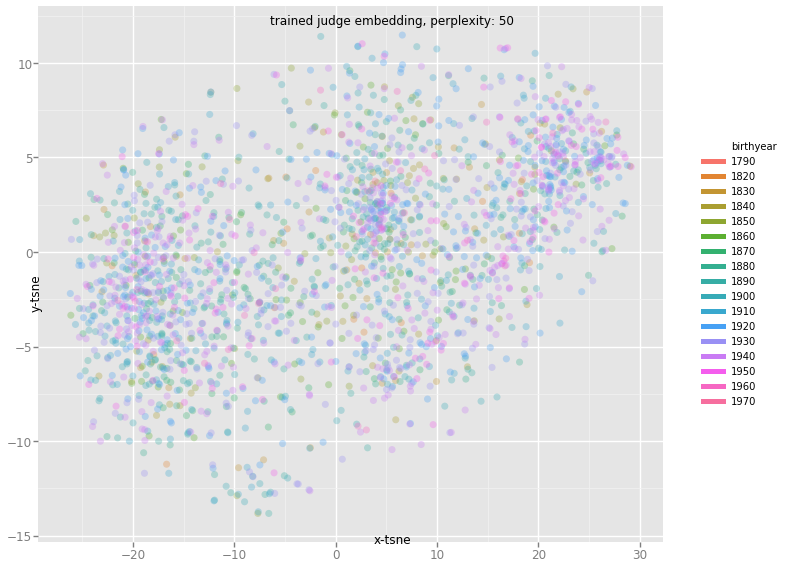

In [48]:
figures_list_trained2[2][5]

## Now we have the tsne plots, we want next to plot similarities between courts and judges

In [45]:
judge_bio_df

,songername,judgeidentificationnumber,Term,id,AppointmentDate,TerminationDate,courtname,courttype,abarating,AbaUpdate,SenateConfirmationdate,RecessAppointDate,birthday,birthmonth,birthyear,deathmonth,deathday,deathyear,JudgeAssignedCourt,judgelastname,judgefirstname,judgemiddlename,suffix,Circuitjudge,SeatState,retirementfromactiveservice,dateaschiefjudgebegin,presidentname,seconddateaschiefjudgebegin,senatevoicevote,senatevoteayesnays,Committeeactiondate,Degree1,Degree2,Degree3,Degree4,Degree5,degreeyear1,degreeyear2,degreeyear3,degreeyear4,degreeyear5,Committeeaction,ageon,vicelastnamepredecessor,vicefirstnamepredecessor,hearings,reportnumber,authorizationlegislation,placeofbirthcity,placeofbirthstate,placeofdeathcity,placeofdeathstate,deathdate,party_Updated,dateaschiefjudgeend,seconddateaschiefjudgeend,renominatingpresidentname,partyaffiliationofrenompres,referraldatejudicialcom,degree,degree_law,degree_other,district,nominationdatesenateexecutivej,genderNew,raceorethnicity,partyaffiliationofpresident,recessappointmentdate,committeeaction,committeeactiondate,senatevotedateconfirmationdate,commissiondate,dateoftermination,terminationspecificreason,nameofschool1,degree1,nameofschool2,degree2,nameofschool3,degree3,nameofschool4,degree4,nameofschool5,degree5,employmenttextfield,bankruptcyandmagistrateservice,Nominationdate,District_Circuit,party,pres,left,state,city,appres,aba,congresi,unityi,hdem,hrep,sdem,srep,hother,sother,x_dem,x_republican,x_instate_ba,x_elev,x_unity,x_aba,x_crossa,x_pfedjdge,x_pindreg1,x_plawprof,x_pscab,x_pcab,x_pusa,x_pssenate,x_paag,x_psp,x_pslc,x_pssc,x_pshouse,x_psg,x_psgo,x_psenate,x_psatty,x_pprivate,x_pmayor,x_plocct,x_phouse,x_pgov,x_pda,x_pcc,x_pccoun,x_pausa,x_pasatty,x_pag,x_pada,x_pgovt,x_llm_sjd,x_protestant,x_evangelical,x_mainline,x_noreligion,x_catholic,x_jewish,x_black,x_nonwhite,x_female,x_jd_public,x_ba_public,x_b10s,x_b20s,x_b30s,x_b40s,x_b50s,x_pbank,x_pmag,SchoolState1,Public1,Private1,SchoolState2,Public2,Private2,SchoolState3,Public3,Private3,SchoolState4,Public4,Private4,SchoolState5,Public5,Private5,TonotInclude,idtocorrrect,ayear,x_ageon40s,x_ageon50s,x_ageon60s,x_ageon40orless,x_ageon70ormore,pres_correct2,political_party,x_pago,startdate
0,"ABRAMS, RONNIE",3419,1,NaN,2012-03-23,NaT,"u. s. district court, southern district of new...",usdc,Qualified,,2012-03-22,NaT,NaN,NaN,1968.0,NaN,NaN,NaN,,ABRAMS,RONNIE,,,2,NY,,NaN,Barack Obama,NaN,No,96/2,2011-11-03,2.0,5.0,NaN,NaN,NaN,1990,1993,,,NaN,1.0,44.0,Kaplan,Lewis A.,10/04/2011,,,New York,NY,,,NaT,NaN,NaN,NaN,,,07/28/2011,,,,0208,07/28/2011,F,White,Democratic,,Reported With Recommendation,11/03/2011,03/22/2012,03/23/2012,,,Cornell University,B.A.,Yale Law School,J.D.,,,,,,,"Law clerk, Hon. Thomas P. Griesa, U.S. Distric...",,18836.0,,NaN,94.0,NaN,NaN,NaN,1.0,3.0,112TH,2.0,193.0,242.0,52,47,0.0,4.0,1.0,0.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NY,0.0,1.0,CT,0.0,1.0,,NaN,NaN,,NaN,NaN,,NaN,NaN,0.0,NaN,2012.0,1.0,0.0,0.0,0.0,0.0,NaN,,0.0,2012-03-23
1,"ABRUZZO, MATTHEW J.",1,1,2.0,1936-02-15,1971-05-28,"u. s. district court, eastern district of new ...",usdc,,,1936-02-12,NaT,30.0,4.0,1889.0,5.0,28.0,1971.0,Brooklyn,ABRUZZO,MATTHEW,T.,,2,NY,02/15/1966,NaN,Franklin D. Roosevelt,NaN,Yes,,1936-02-11,6.0,NaN,NaN,NaN,NaN,1910,,,,NaN,1.0,47.0,new,,,,49 Stat. 659,Brooklyn,NY,Potomac,MD,1971-05-28,1.0,NaN,NaN,,,02/03/1936,,,,0207,02/03/1936,M,White,Democratic,,Reported With Recommendation,02/11/1936,02/12/1936,02/15/1936,05/28/1971,Death,Brooklyn Law School,LL.B.,,,,,,,,,"Private practice, Brooklyn, New York, 1910-1936",,-8733.0,0207,1.0,14.0,3.0,32.0,3220.0,1.0,6.0,74TH,0.0,322.0,103.0,69,25,0.0,2.0,1.0,0.0,0.0,NaN,1.0,0.0,0.0,NaN,1.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

In [29]:
## we first get the embedding for each court
## that's basically each court's embedding is the average of all embedding of judges who are on that court
def get_court_emb(judge_emb,judgeIndex2Id,judge_bio_df):
    n_judge = judge_emb.shape[0]
    court_emb = np.zeros((14,judge_emb.shape[1]))
    court_emb_count = np.zeros(14)
    
    for i in range(n_judge):
        judge_id = judgeIndex2Id[i]
        judge_bio = judge_bio_df.loc[judge_bio_df['judgeidentificationnumber']==judge_id].iloc[0]
        judge_court = judge_bio['Circuitjudge']
        court_emb[judge_court] += judge_emb[i,:]
        court_emb_count[judge_court] += 1
    # then get average
    for j in range(14):
        if court_emb_count[j] != 0:
            court_emb[j] /= court_emb_count[j]
            
    return court_emb

def get_similarity_matrix(emb):
    # given NxD embedding matrix, give back NxN similarity matrix
    return sklearn.metrics.pairwise.cosine_similarity(emb)


## We now plot court-court similarities

In [59]:
court_sim_matrix.shape
court_sim_matrix

(14, 14)

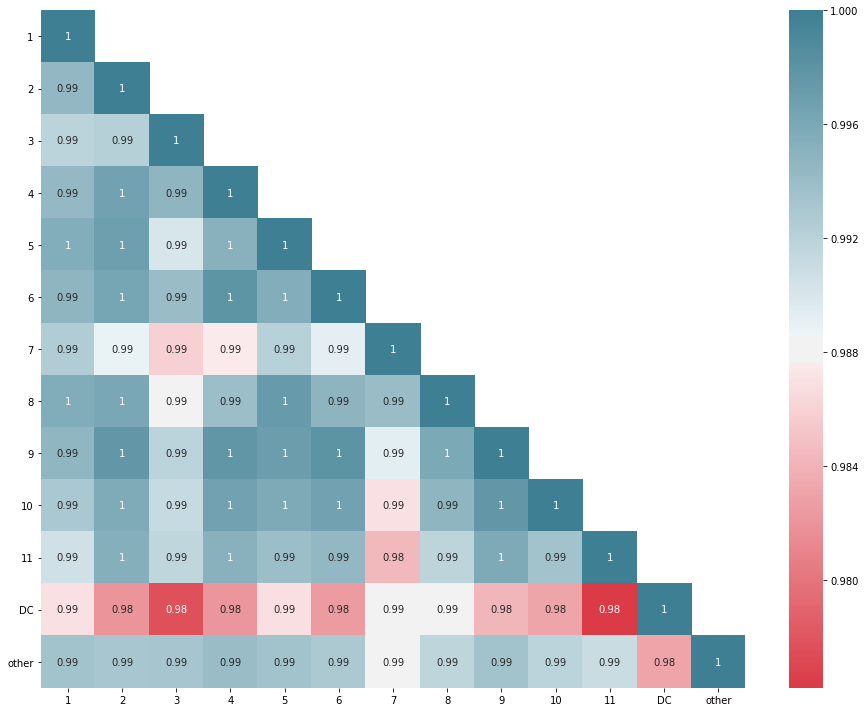

In [60]:
judge_emb = no_fed_judge_emb
save_name = "court_sim_no_fed.png"
court_emb = get_court_emb(judge_emb, judgeIndex2Id, judge_bio_df)
court_sim_matrix = get_similarity_matrix(court_emb)
court_sim_matrix = court_sim_matrix[1:,1:]

mask = np.ones_like(court_sim_matrix, dtype=np.bool)
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(10, 220, as_cmap=True)

a4_dims = (13, 10)
fig, ax = plt.subplots(figsize=a4_dims)

circuit_labels = [1,2,3,4,5,6,7,8,9,10,11,"DC","other"]

ax = sns.heatmap(court_sim_matrix,mask=mask,cmap=cmap,annot=True,xticklabels=circuit_labels,yticklabels=circuit_labels)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)

court_sim_figure = plt.gcf()
plt.tight_layout()
court_sim_fig_savepath = os.path.join(plot_save_path,save_name)
court_sim_figure.savefig(court_sim_fig_savepath)
# 0 and 12 means federal and DC (Distric of Columbia)

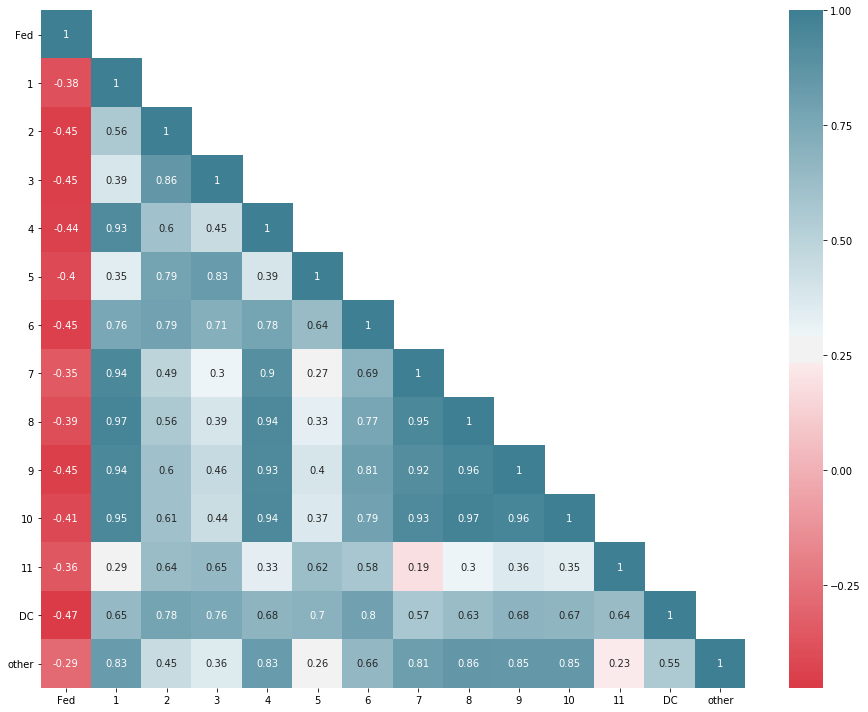

In [31]:
judge_emb = pred_ruling_judge_emb
save_name = "court_sim_pred_ruling.png"
court_emb = get_court_emb(judge_emb, judgeIndex2Id, judge_bio_df)
court_sim_matrix = get_similarity_matrix(court_emb)

mask = np.ones_like(court_sim_matrix, dtype=np.bool)
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(10, 220, as_cmap=True)

a4_dims = (13, 10)
fig, ax = plt.subplots(figsize=a4_dims)

circuit_labels = ["Fed",1,2,3,4,5,6,7,8,9,10,11,"DC","other"]

ax = sns.heatmap(court_sim_matrix,mask=mask,cmap=cmap,annot=True,xticklabels=circuit_labels,yticklabels=circuit_labels)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)

court_sim_figure = plt.gcf()
plt.tight_layout()
court_sim_fig_savepath = os.path.join(plot_save_path,save_name)
court_sim_figure.savefig(court_sim_fig_savepath)
# 0 and 12 means federal and DC (Distric of Columbia)

## next we want to get judge similarity scores, so we need to 

In [49]:
# we need a name-id and id-name dictionary
def getNameIdDicts(judge_bio_df):
    n_instance = judge_bio_df.shape[0]
    judge_name2Id_dict = {}
    judge_id2Name_dict = {}
    
    for i in range(n_instance):
        row = judge_bio_df.iloc[i]
        songername = row['songername']
        judge_id = row['judgeidentificationnumber']
        if songername not in judge_name2Id_dict:
            judge_name2Id_dict[songername] = judge_id
            judge_id2Name_dict[judge_id] = songername
            
    return judge_name2Id_dict, judge_id2Name_dict


judge_name2Id_dict, judge_id2Name_dict = getNameIdDicts(judge_bio_df)

In [50]:
judge_name2Id_dict['POSNER, RICHARD A.']

1922

In [51]:
# these are 15 most similar judges to Richard Posner
list_of_judge_names = ['POSNER, RICHARD A.','EASTERBROOK, FRANK H.','SUTTON, JEFFREY S.',
                       'NOONAN, JOHN T.','NELSON, DAVID A.','CARNES, EDWARD E.',
                       'FRIENDLY, HENRY','KOZINSKI, ALEX','GORSUCH, NEIL M.',
                       'CHAMBERS, RICHARD H.', 'FERNANDEZ, FERDINAND F.','EDMONDSON, JAMES L.',
                       'KLEINFELD, ANDREW J.','WILLIAMS, STEPHEN F.','KETHLEDGE, RAYMOND M.' ]
def getListOfIndexFromNames(list_of_names):
    listOfIndex = []
    for name in list_of_names:
        judge_id = judge_name2Id_dict[name]
        judge_index = judgeId2Index[judge_id]
        listOfIndex.append(judge_index)
    return listOfIndex
listOfIndex = getListOfIndexFromNames(list_of_judge_names)

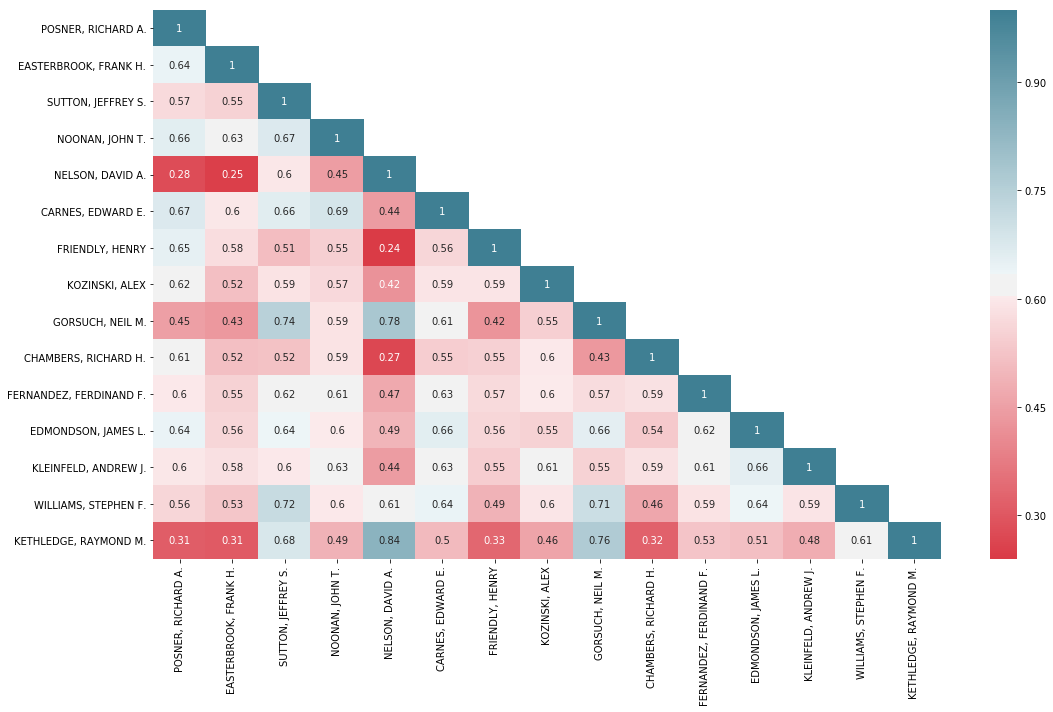

In [52]:
try_judge = no_fed_judge_emb[listOfIndex]
save_name = "judge_sim_no_fed.png"
judge_sim_matrix = get_similarity_matrix(try_judge)

mask = np.ones_like(judge_sim_matrix, dtype=np.bool)
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(10, 220, as_cmap=True)

a4_dims = (16, 10)
fig, ax = plt.subplots(figsize=a4_dims)

ax = sns.heatmap(judge_sim_matrix,mask=mask,cmap=cmap,annot=True,xticklabels=list_of_judge_names,yticklabels=list_of_judge_names)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)

fig = plt.gcf()
plt.tight_layout()
judge_sim_fig_savepath = os.path.join(plot_save_path,save_name)
fig.savefig(judge_sim_fig_savepath)
# 0 and 12 means federal and DC (Distric of Columbia)

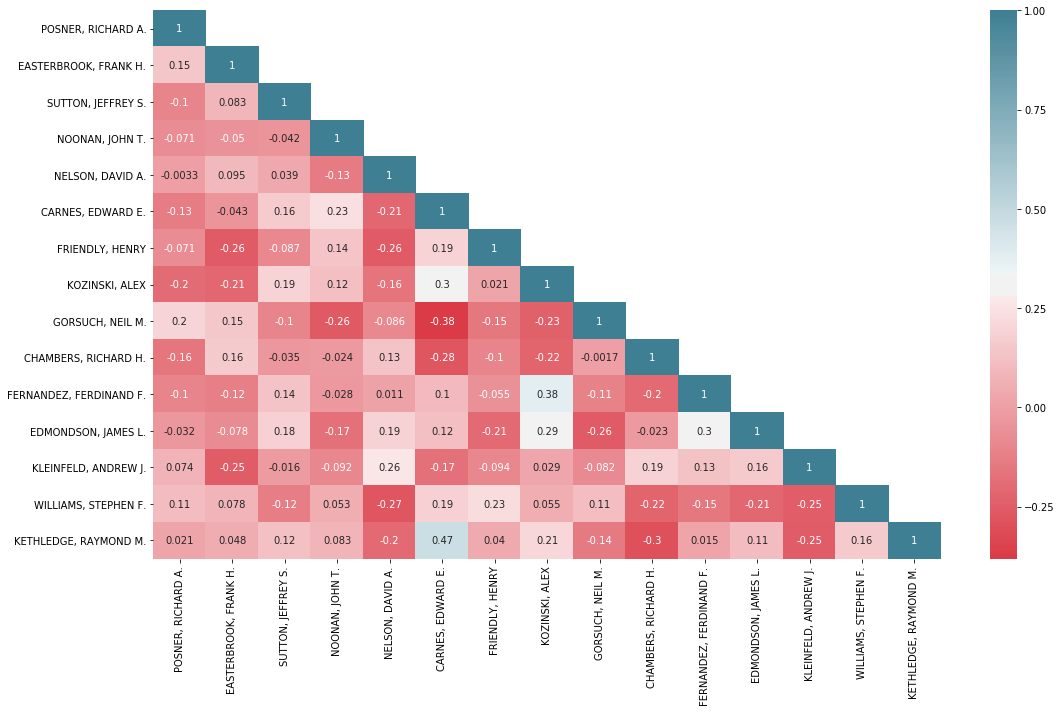

In [53]:
try_judge = pred_ruling_judge_emb[listOfIndex]
save_name = "judge_sim_pred_ruling.png"

judge_sim_matrix = get_similarity_matrix(try_judge)

mask = np.ones_like(judge_sim_matrix, dtype=np.bool)
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(10, 220, as_cmap=True)

a4_dims = (16, 10)
fig, ax = plt.subplots(figsize=a4_dims)

ax = sns.heatmap(judge_sim_matrix,mask=mask,cmap=cmap,annot=True,xticklabels=list_of_judge_names,yticklabels=list_of_judge_names)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)

fig = plt.gcf()
plt.tight_layout()
judge_sim_fig_savepath = os.path.join(plot_save_path,save_name)
fig.savefig(judge_sim_fig_savepath)
# 0 and 12 means federal and DC (Distric of Columbia)

## now we look at specific judges and see who are most similar or different to them

In [54]:
# now we try to figure out who are most similar to Posner and who are most different
def get_most_similar_judges(judge_of_interest, judge_emb, 
                            judge_name2Id_dict, judge_id2Name_dict, judgeIndex2Id, judgeId2Index):
    # give a judge's name,
    # give back a list of most similar judges
    n_judges = judge_emb.shape[0]
    
    joi_index = judgeId2Index[judge_name2Id_dict[judge_of_interest]]  
    joi_emb = judge_emb[joi_index]
    
    scores_df = pd.DataFrame()
    
    names = []
    for i in range(n_judges):
        name = judge_id2Name_dict[judgeIndex2Id[i]]
        names.append(name)
    scores_df['name'] = names
    
    score_list = sklearn.metrics.pairwise.cosine_similarity(joi_emb.reshape(1,-1), judge_emb).reshape(-1,1)
    
    scores_df['score'] = score_list
    
    return scores_df

In [55]:
pd.options.display.max_rows = 30

In [56]:
judge_emb = no_fed_judge_emb
most_sim = get_most_similar_judges('POSNER, RICHARD A.', judge_emb, 
                            judge_name2Id_dict, judge_id2Name_dict, judgeIndex2Id, judgeId2Index)
most_sim.sort_values('score',ascending=False)

,name,score
1193,"POSNER, RICHARD A.",1.000000
803,"HEANEY, GERALD",0.741637
1363,"WOLLMAN, ROGER L.",0.724517
1436,"KANNE, MICHAEL S.",0.721932
1282,"SELYA, BRUCE M.",0.713584
1385,"MAGILL, FRANK J.",0.713453
1327,"RIPPLE, KENNETH F.",0.710276
1155,"BOOCHEVER, ROBERT",0.700561
821,"HOLLOWAY, WILLIAM",0.697308
1074,"FLAUM, JOEL M.",0.695789


In [57]:
judge_emb = pred_ruling_judge_emb
most_sim = get_most_similar_judges('POSNER, RICHARD A.', judge_emb, 
                            judge_name2Id_dict, judge_id2Name_dict, judgeIndex2Id, judgeId2Index)
most_sim.sort_values('score',ascending=False)

,name,score
1193,"POSNER, RICHARD A.",1.000000
340,"WATSON, ALBERT LEISENRING",0.285062
1781,"BLAKE, CATHERINE C.",0.280935
1553,"GARBIS, MARVIN J.",0.277878
384,"MILLER, JUSTIN",0.276828
1448,"HUTCHINSON, WILLIAM D.",0.269340
597,"BOYD, MARION SPEED",0.268200
1329,"BURCIAGA, JUAN GUERRERO",0.263905
336,"GLENN, JOHN LYLES, JR.",0.261743
1139,"KIDD, WILLIAM MATTHEW",0.260840
